In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q /content/drive/MyDrive/processed_crops.zip -d /content/kaggle_dataset_cw_enriched_v3/

In [2]:
!unzip -q /content/drive/MyDrive/processed_crops_v2.zip -d /content/kaggle_dataset_cw_enriched_v4/

In [3]:
import os
import shutil
import numpy as np
import pandas as pd

from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

In [4]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
DATASET_DIR = "/content/kaggle_dataset_cw_enriched_v4/processed_crops_v2"

train_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int'  # use 'categorical' if labels are one-hot
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int'
)

# Normalize
def normalize(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_ds = train_ds.map(normalize).shuffle(1000).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.map(normalize).prefetch(tf.data.AUTOTUNE)

# Model
base_model = tf.keras.applications.ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False

from tensorflow.keras import layers, models

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(train_ds.cardinality().numpy(), activation='softmax')  # OR use `len(class_names)`
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Early stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# ✅ Train
history = model.fit(train_ds, validation_data=test_ds, epochs=50, callbacks=[early_stopping])


Found 76826 files belonging to 52 classes.
Using 61461 files for training.
Found 76826 files belonging to 52 classes.
Using 15365 files for validation.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50
1921/1921 ━━━━━━━━━━━━━━━━━━━━ 88s 28ms/step - accuracy: 0.1527 - loss: 3.4100 - val_accuracy: 0.2648 - val_loss: 2.6547
Epoch 2/50
1921/1921 ━━━━━━━━━━━━━━━━━━━━ 39s 19ms/step - accuracy: 0.3036 - loss: 2.5555 - val_accuracy: 0.3687 - val_loss: 2.2650
Epoch 3/50
1921/1921 ━━━━━━━━━━━━━━━━━━━━ 39s 19ms/step - accuracy: 0.3891 - loss: 2.1987 - val_accuracy: 0.4241 - val_loss: 2.0456
Epoch 4/50
1921/1921 ━━━━━━━━━━━━━━━━━━━━ 39s 19ms/step - accuracy: 0.4348 - loss: 1.9920 - val_accuracy: 0.4372 - val_loss: 1.9485
Epoch 5/50
1921/1921 ━━━━━━━━━━━━━━━━━━━━ 39s 19ms/step - accuracy: 0.4583 - loss: 1.8890 - val_accuracy: 0.4599 - val_loss: 1.8370
Epoch 6/50
1921/1921 ━━━━━━━━━━━━━━━━━━━━ 39s 19ms/step - accuracy: 0.4760 - loss: 1.8006 - val_accuracy: 0.4868 - val_loss: 1.7613
Epoch

In [5]:
predictions = model.predict(test_ds)
predicted_labels = tf.argmax(predictions, axis=1)
true_labels = [label for _, label in test_ds.unbatch()]
print(classification_report(true_labels, predicted_labels))

481/481 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step
              precision    recall  f1-score   support

           0       0.04      0.01      0.02       148
           1       0.00      0.01      0.01       127
           2       0.00      0.00      0.00        81
           3       0.02      0.03      0.03       376
           4       0.01      0.01      0.01       308
           5       0.01      0.01      0.01       210
           6       0.03      0.02      0.02       171
           7       0.00      0.00      0.00        28
           8       0.01      0.01      0.01       116
           9       0.03      0.03      0.03       260
          10       0.02      0.02      0.02       243
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00         5
          13       0.01      0.01      0.01       193
          14       0.00      0.00      0.00        82
          15       0.00      0.00      0.00         7
          16       0.00      0.00     

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [6]:
import numpy as np
from tqdm import tqdm

y_true = []
y_pred = []

# Loop through the entire test set
for batch in tqdm(test_ds, desc="Evaluating"):
    images, labels = batch
    preds = model.predict(images, verbose=0)

    y_true.extend(labels.numpy() if hasattr(labels, 'numpy') else labels)
    y_pred.extend(np.argmax(preds, axis=1))      # Predicted labels

y_true = np.array(y_true)
y_pred = np.array(y_pred)





Evaluating: 100%|██████████| 481/481 [00:49<00:00,  9.66it/s]


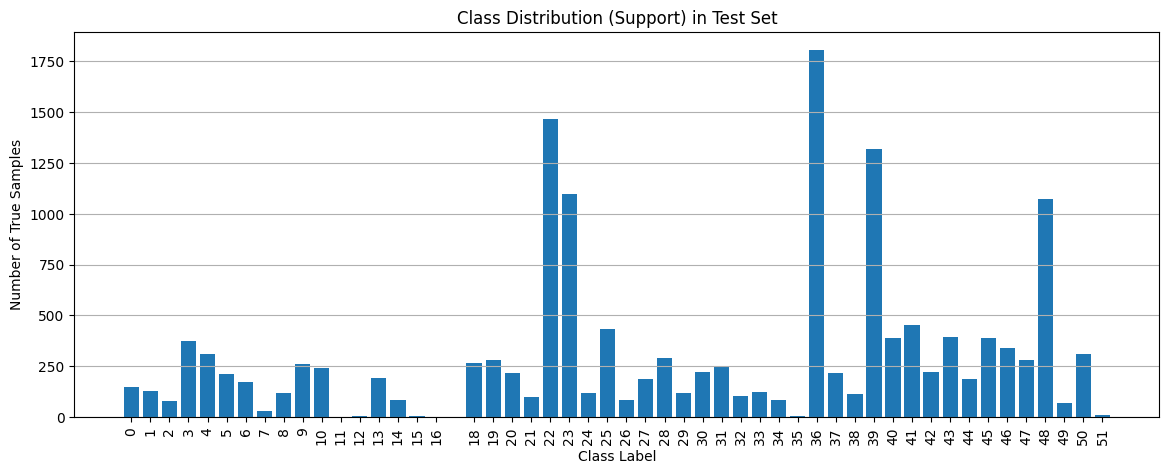

In [7]:
from collections import Counter
import matplotlib.pyplot as plt

support_counter = Counter(y_true)
labels, supports = zip(*sorted(support_counter.items()))

plt.figure(figsize=(14, 5))
plt.bar(labels, supports)
plt.xticks(labels, rotation=90)
plt.title("Class Distribution (Support) in Test Set")
plt.xlabel("Class Label")
plt.ylabel("Number of True Samples")
plt.grid(True, axis='y')
plt.show()

In [8]:
# Step 1: Compute class weights only for present labels
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

unique_labels = np.unique(y_true)

# Compute class weights just for labels in use
weights = compute_class_weight(
    class_weight='balanced',
    classes=unique_labels,
    y=y_true
)
partial_weights = dict(zip(unique_labels, weights))

# Step 2: Create full class_weight dictionary for all 1921 classes
num_classes = 1921
class_weights = {i: partial_weights.get(i, 1.0) for i in range(num_classes)}


# Then pass to model.fit():
model.fit(train_ds, validation_data=test_ds, class_weight=class_weights, epochs=50)


Epoch 1/50
1921/1921 ━━━━━━━━━━━━━━━━━━━━ 51s 21ms/step - accuracy: 0.4089 - loss: 2.1799 - val_accuracy: 0.3171 - val_loss: 2.4200
Epoch 2/50
1921/1921 ━━━━━━━━━━━━━━━━━━━━ 40s 19ms/step - accuracy: 0.3772 - loss: 2.0873 - val_accuracy: 0.4379 - val_loss: 1.9089
Epoch 3/50
1921/1921 ━━━━━━━━━━━━━━━━━━━━ 40s 19ms/step - accuracy: 0.4302 - loss: 1.8656 - val_accuracy: 0.3276 - val_loss: 2.3661
Epoch 4/50
1921/1921 ━━━━━━━━━━━━━━━━━━━━ 40s 19ms/step - accuracy: 0.3903 - loss: 1.9798 - val_accuracy: 0.1976 - val_loss: 3.1890
Epoch 5/50
1921/1921 ━━━━━━━━━━━━━━━━━━━━ 40s 19ms/step - accuracy: 0.4216 - loss: 1.8471 - val_accuracy: 0.4366 - val_loss: 1.9582
Epoch 6/50
1921/1921 ━━━━━━━━━━━━━━━━━━━━ 40s 19ms/step - accuracy: 0.4274 - loss: 1.8877 - val_accuracy: 0.3892 - val_loss: 2.0695
Epoch 7/50
1921/1921 ━━━━━━━━━━━━━━━━━━━━ 39s 19ms/step - accuracy: 0.4071 - loss: 1.9697 - val_accuracy: 0.4092 - val_loss: 2.0934
Epoch 8/50
1921/1921 ━━━━━━━━━━━━━━━━━━━━ 40s 19ms/step - accuracy: 0.4278 -

In [9]:
import os
import random
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import shutil
from collections import defaultdict
from tqdm import tqdm

# ==== Parameters ====
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
MAX_SAMPLES_PER_CLASS = 200  # ⬅️ set your downsampling threshold
DATASET_DIR = "/content/kaggle_dataset_cw_enriched_v4/processed_crops_v2"

# ==== 📦 Step 1: Downsample folders ====
def downsample_folder(dataset_dir, max_per_class=500):
    print(f"Downsampling to max {max_per_class} samples per class...")
    for class_dir in os.listdir(dataset_dir):
        class_path = os.path.join(dataset_dir, class_dir)
        if not os.path.isdir(class_path):
            continue

        images = os.listdir(class_path)
        if len(images) > max_per_class:
            to_remove = random.sample(images, len(images) - max_per_class)
            for img in to_remove:
                os.remove(os.path.join(class_path, img))
    print("✅ Downsampling complete.")

downsample_folder(DATASET_DIR, MAX_SAMPLES_PER_CLASS)

# ==== 📥 Step 2: Load datasets ====
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int'
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int'
)

class_names = train_ds.class_names
num_classes = len(class_names)

# ==== 🔄 Step 3: Normalize and Prefetch ====
def normalize(image, label):
    return tf.cast(image, tf.float32) / 255.0, label

train_ds = train_ds.map(normalize).shuffle(1000).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.map(normalize).prefetch(tf.data.AUTOTUNE)

# ==== 🧠 Step 4: Build Model ====
base_model = tf.keras.applications.ResNet50(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# ==== 🚀 Step 5: Train ====
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=50,
    callbacks=[early_stopping]
)


Downsampling to max 200 samples per class...
✅ Downsampling complete.
Found 9095 files belonging to 52 classes.
Using 7276 files for training.
Found 9095 files belonging to 52 classes.
Using 1819 files for validation.
Epoch 1/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 30s 80ms/step - accuracy: 0.0273 - loss: 3.9278 - val_accuracy: 0.0418 - val_loss: 3.8107
Epoch 2/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.0448 - loss: 3.7893 - val_accuracy: 0.0566 - val_loss: 3.7226
Epoch 3/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.0662 - loss: 3.7058 - val_accuracy: 0.0649 - val_loss: 3.6253
Epoch 4/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.0807 - loss: 3.5933 - val_accuracy: 0.0863 - val_loss: 3.5307
Epoch 5/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.1060 - loss: 3.4944 - val_accuracy: 0.1754 - val_loss: 3.4194
Epoch 6/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.1272 - loss: 3.4048 - val_accuracy: 0.1396 - val_loss: 3.3610
Epoch 7

In [72]:
# Unfreeze the base model
base_model.trainable = True

# Recompile with a lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tune
history_finetune = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=50,  # fewer epochs are usually enough
    callbacks=[early_stopping]
)


Epoch 1/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 87s 154ms/step - accuracy: 0.8256 - loss: 0.6937 - val_accuracy: 0.8609 - val_loss: 0.5687
Epoch 2/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 12s 51ms/step - accuracy: 0.8959 - loss: 0.3711 - val_accuracy: 0.8730 - val_loss: 0.5326
Epoch 3/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 12s 51ms/step - accuracy: 0.9273 - loss: 0.2621 - val_accuracy: 0.8714 - val_loss: 0.5203
Epoch 4/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - accuracy: 0.9459 - loss: 0.1929 - val_accuracy: 0.8758 - val_loss: 0.5205
Epoch 5/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - accuracy: 0.9641 - loss: 0.1359 - val_accuracy: 0.8796 - val_loss: 0.5039
Epoch 6/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - accuracy: 0.9705 - loss: 0.0999 - val_accuracy: 0.8879 - val_loss: 0.5374
Epoch 7/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - accuracy: 0.9778 - loss: 0.0888 - val_accuracy: 0.8835 - val_loss: 0.5270
Epoch 8/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - accuracy: 0.9844 - loss: 0.0709 -

Figure saved to training_curves_base.png
Figure saved to training_curves_finetune.png


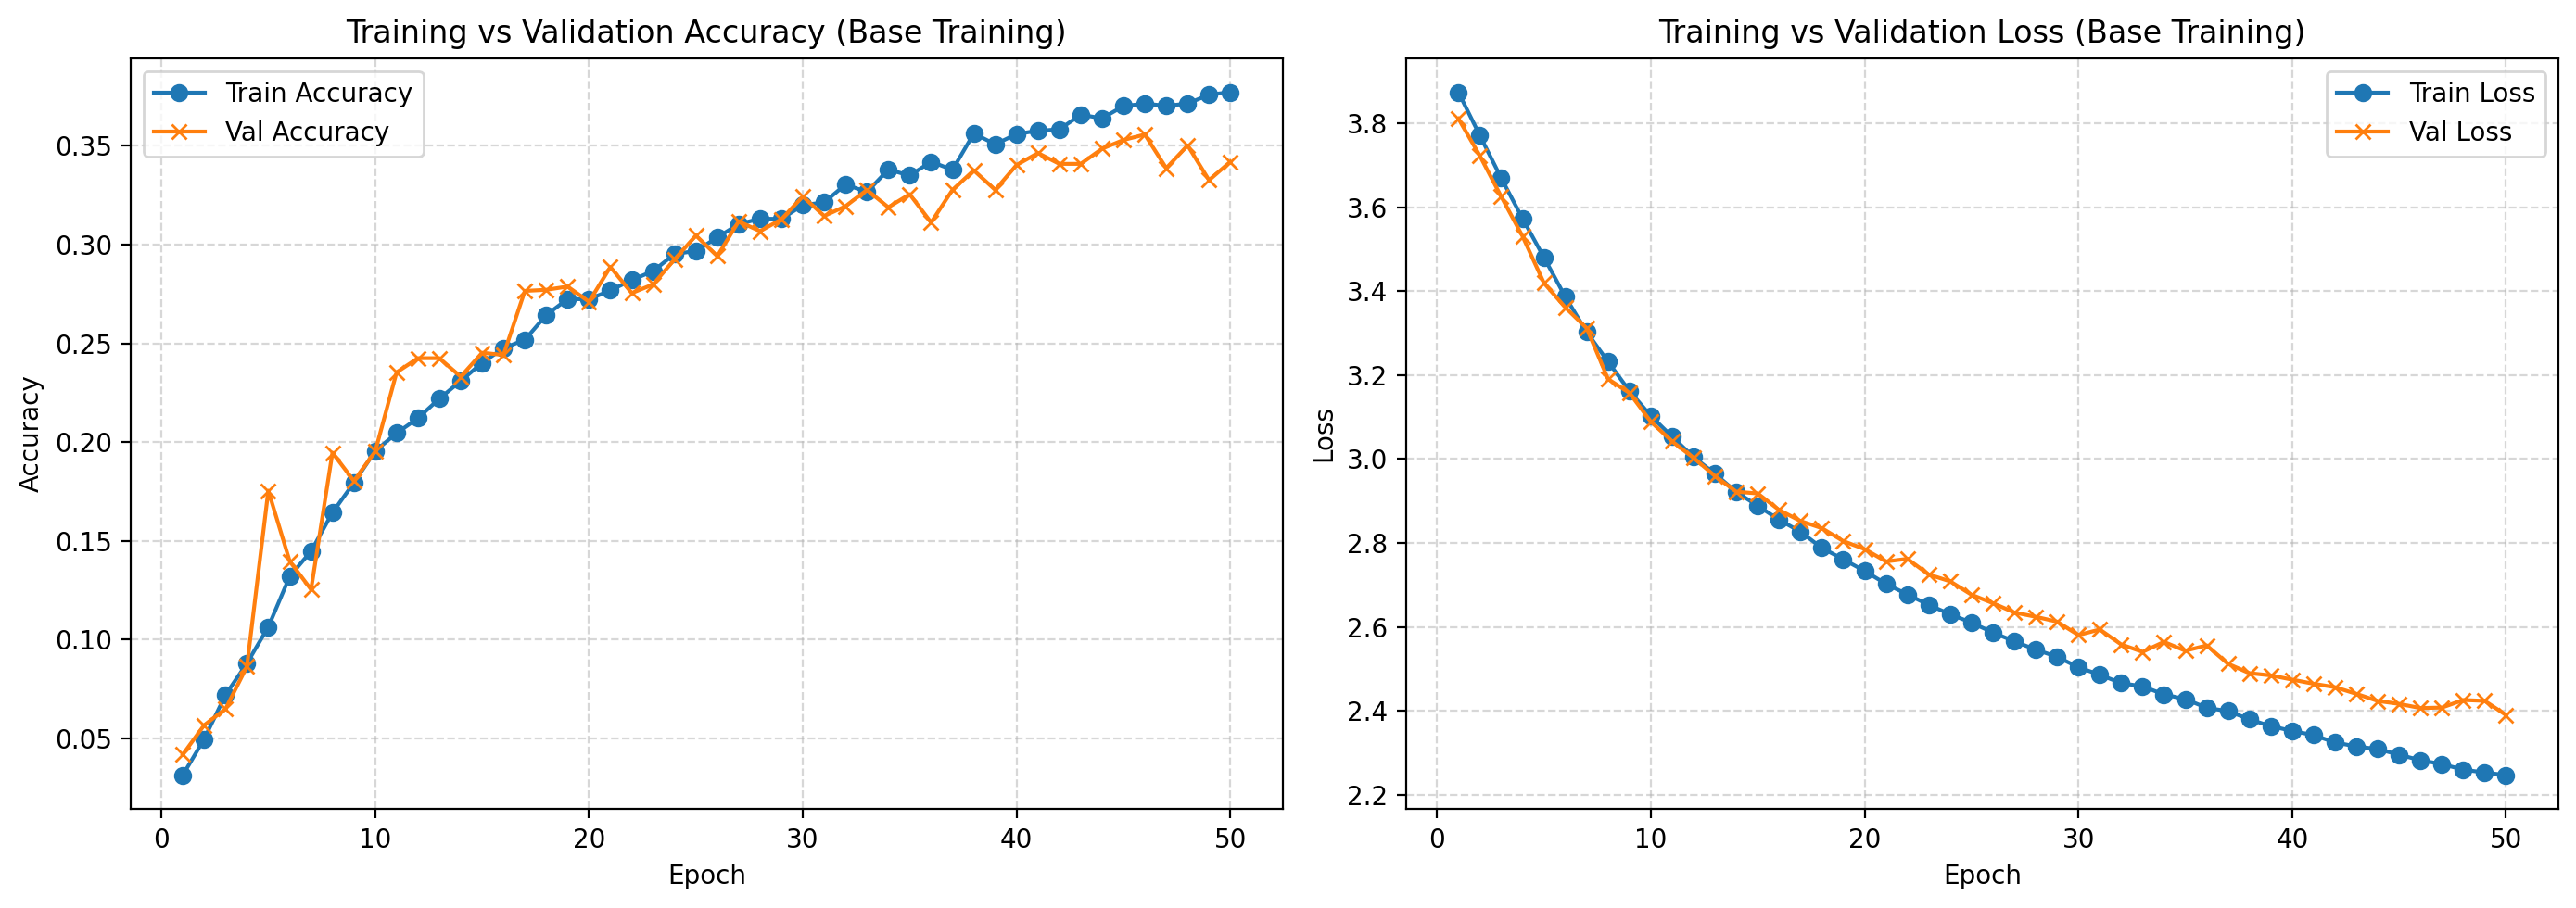

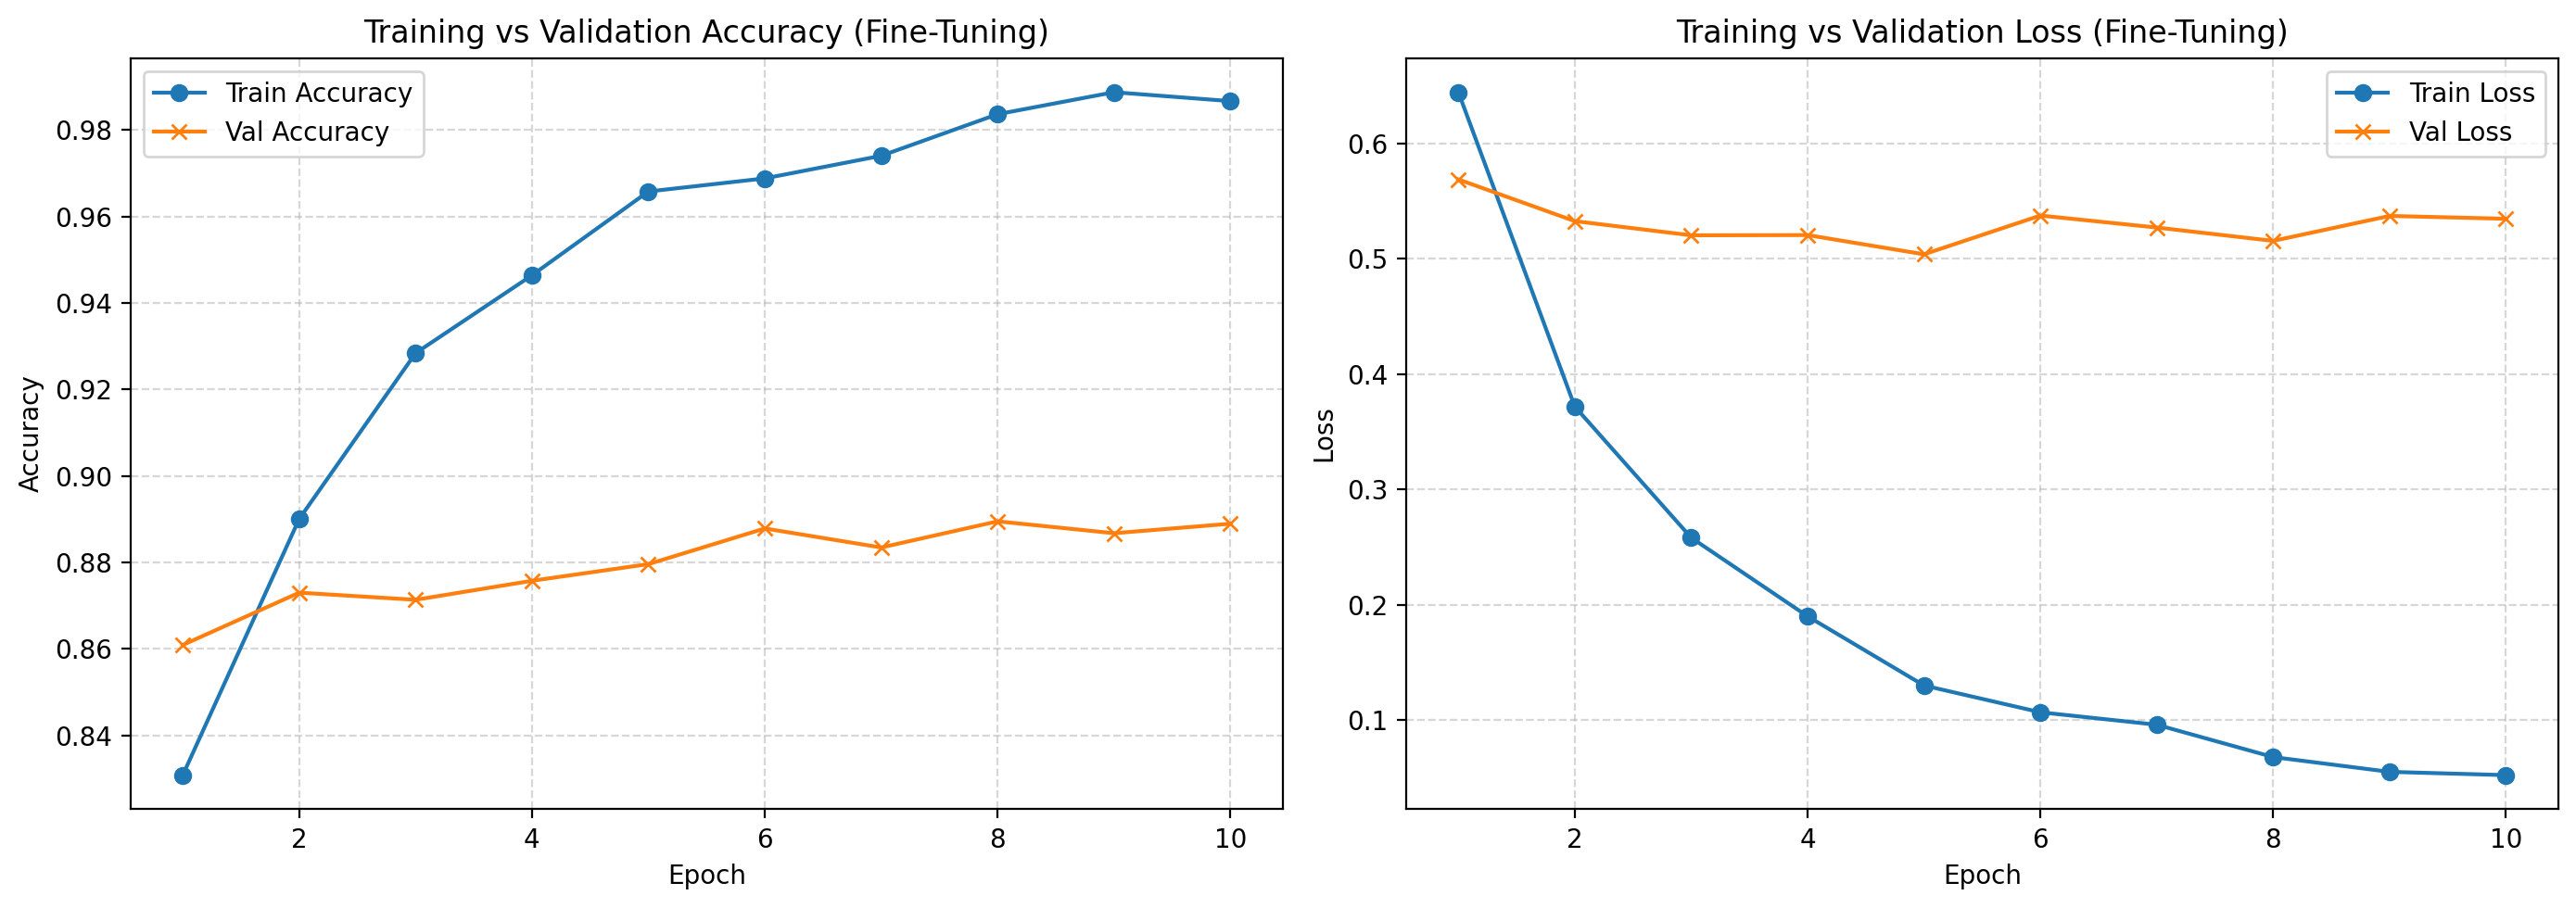

In [74]:
import matplotlib.pyplot as plt

def plot_history(hist, title_suffix="", dpi=150, save_path=None):
    """
    Plot accuracy & loss curves for a Keras History object.

    Parameters
    ----------
    hist : tf.keras.callbacks.History
        The history returned by `model.fit`.
    title_suffix : str, optional
        Added to plot titles to distinguish multiple runs.
    dpi : int, optional
        Dots-per-inch for the figure; raise it for sharper text/lines.
    save_path : str or None, optional
        If set, the figure is saved (PNG); otherwise just shown.
    """

    # ---- Extract metrics ----
    acc      = hist.history.get("accuracy", [])
    val_acc  = hist.history.get("val_accuracy", [])
    loss     = hist.history.get("loss", [])
    val_loss = hist.history.get("val_loss", [])

    epochs = range(1, len(acc) + 1)

    # ---- Create the figure ----
    plt.figure(figsize=(14, 5), dpi=dpi)

    # Accuracy subplot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc,      marker="o", label="Train Accuracy")
    plt.plot(epochs, val_acc,  marker="x", label="Val Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"Training vs Validation Accuracy{title_suffix}")
    plt.grid(True, ls="--", alpha=0.5)
    plt.legend()

    # Loss subplot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss,     marker="o", label="Train Loss")
    plt.plot(epochs, val_loss, marker="x", label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Training vs Validation Loss{title_suffix}")
    plt.grid(True, ls="--", alpha=0.5)
    plt.legend()

    plt.tight_layout()

    # ---- Save or show ----
    if save_path:
        plt.savefig(save_path, format="png", dpi=dpi, bbox_inches="tight")
        print(f"Figure saved to {save_path}")
    else:
        plt.show()

# 1️⃣ First training phase
plot_history(history, title_suffix=" (Base Training)", dpi=200,
             save_path="training_curves_base.png")

# 2️⃣ Fine-tuning phase
plot_history(history_finetune, title_suffix=" (Fine-Tuning)", dpi=200,
             save_path="training_curves_finetune.png")

In [11]:
data_augment = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# Apply during training
train_ds = train_ds.map(lambda x, y: (data_augment(x, training=True), y))


In [12]:
raw_train_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int'
)

raw_val_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int'
)

# ✅ Save class names before map()
class_names = raw_train_ds.class_names

# Apply normalization
train_ds = raw_train_ds.map(normalize).shuffle(1000).prefetch(tf.data.AUTOTUNE)
test_ds = raw_val_ds.map(normalize).prefetch(tf.data.AUTOTUNE)


Found 9095 files belonging to 52 classes.
Using 7276 files for training.
Found 9095 files belonging to 52 classes.
Using 1819 files for validation.


In [13]:
from sklearn.metrics import classification_report
import numpy as np

# Run prediction
y_true = []
y_pred = []

for batch in test_ds:
    images, labels = batch
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Ensure correct mapping
num_classes = len(class_names)
label_indices = list(range(num_classes))  # [0, 1, ..., 51]

# Generate report
print(classification_report(
    y_true, y_pred,
    labels=label_indices,
    target_names=class_names,
    digits=3,
    zero_division=0  # avoid warning on precision/recall = 0
))


                                                    precision    recall  f1-score   support

                                Apple___Apple_scab      0.680     0.405     0.507        42
                                 Apple___Black_rot      0.939     0.939     0.939        33
                          Apple___Cedar_apple_rust      0.775     0.689     0.729        45
                                   Apple___healthy      0.811     0.896     0.851        48
                               Blueberry___healthy      0.906     0.906     0.906        32
          Cherry_(including_sour)___Powdery_mildew      0.881     0.925     0.902        40
                 Cherry_(including_sour)___healthy      0.860     0.956     0.905        45
                             Common_bean___healthy      0.786     0.524     0.629        21
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot      0.745     0.833     0.787        42
                        Corn_(maize)___Common_rust      0.796     0.886     0.8

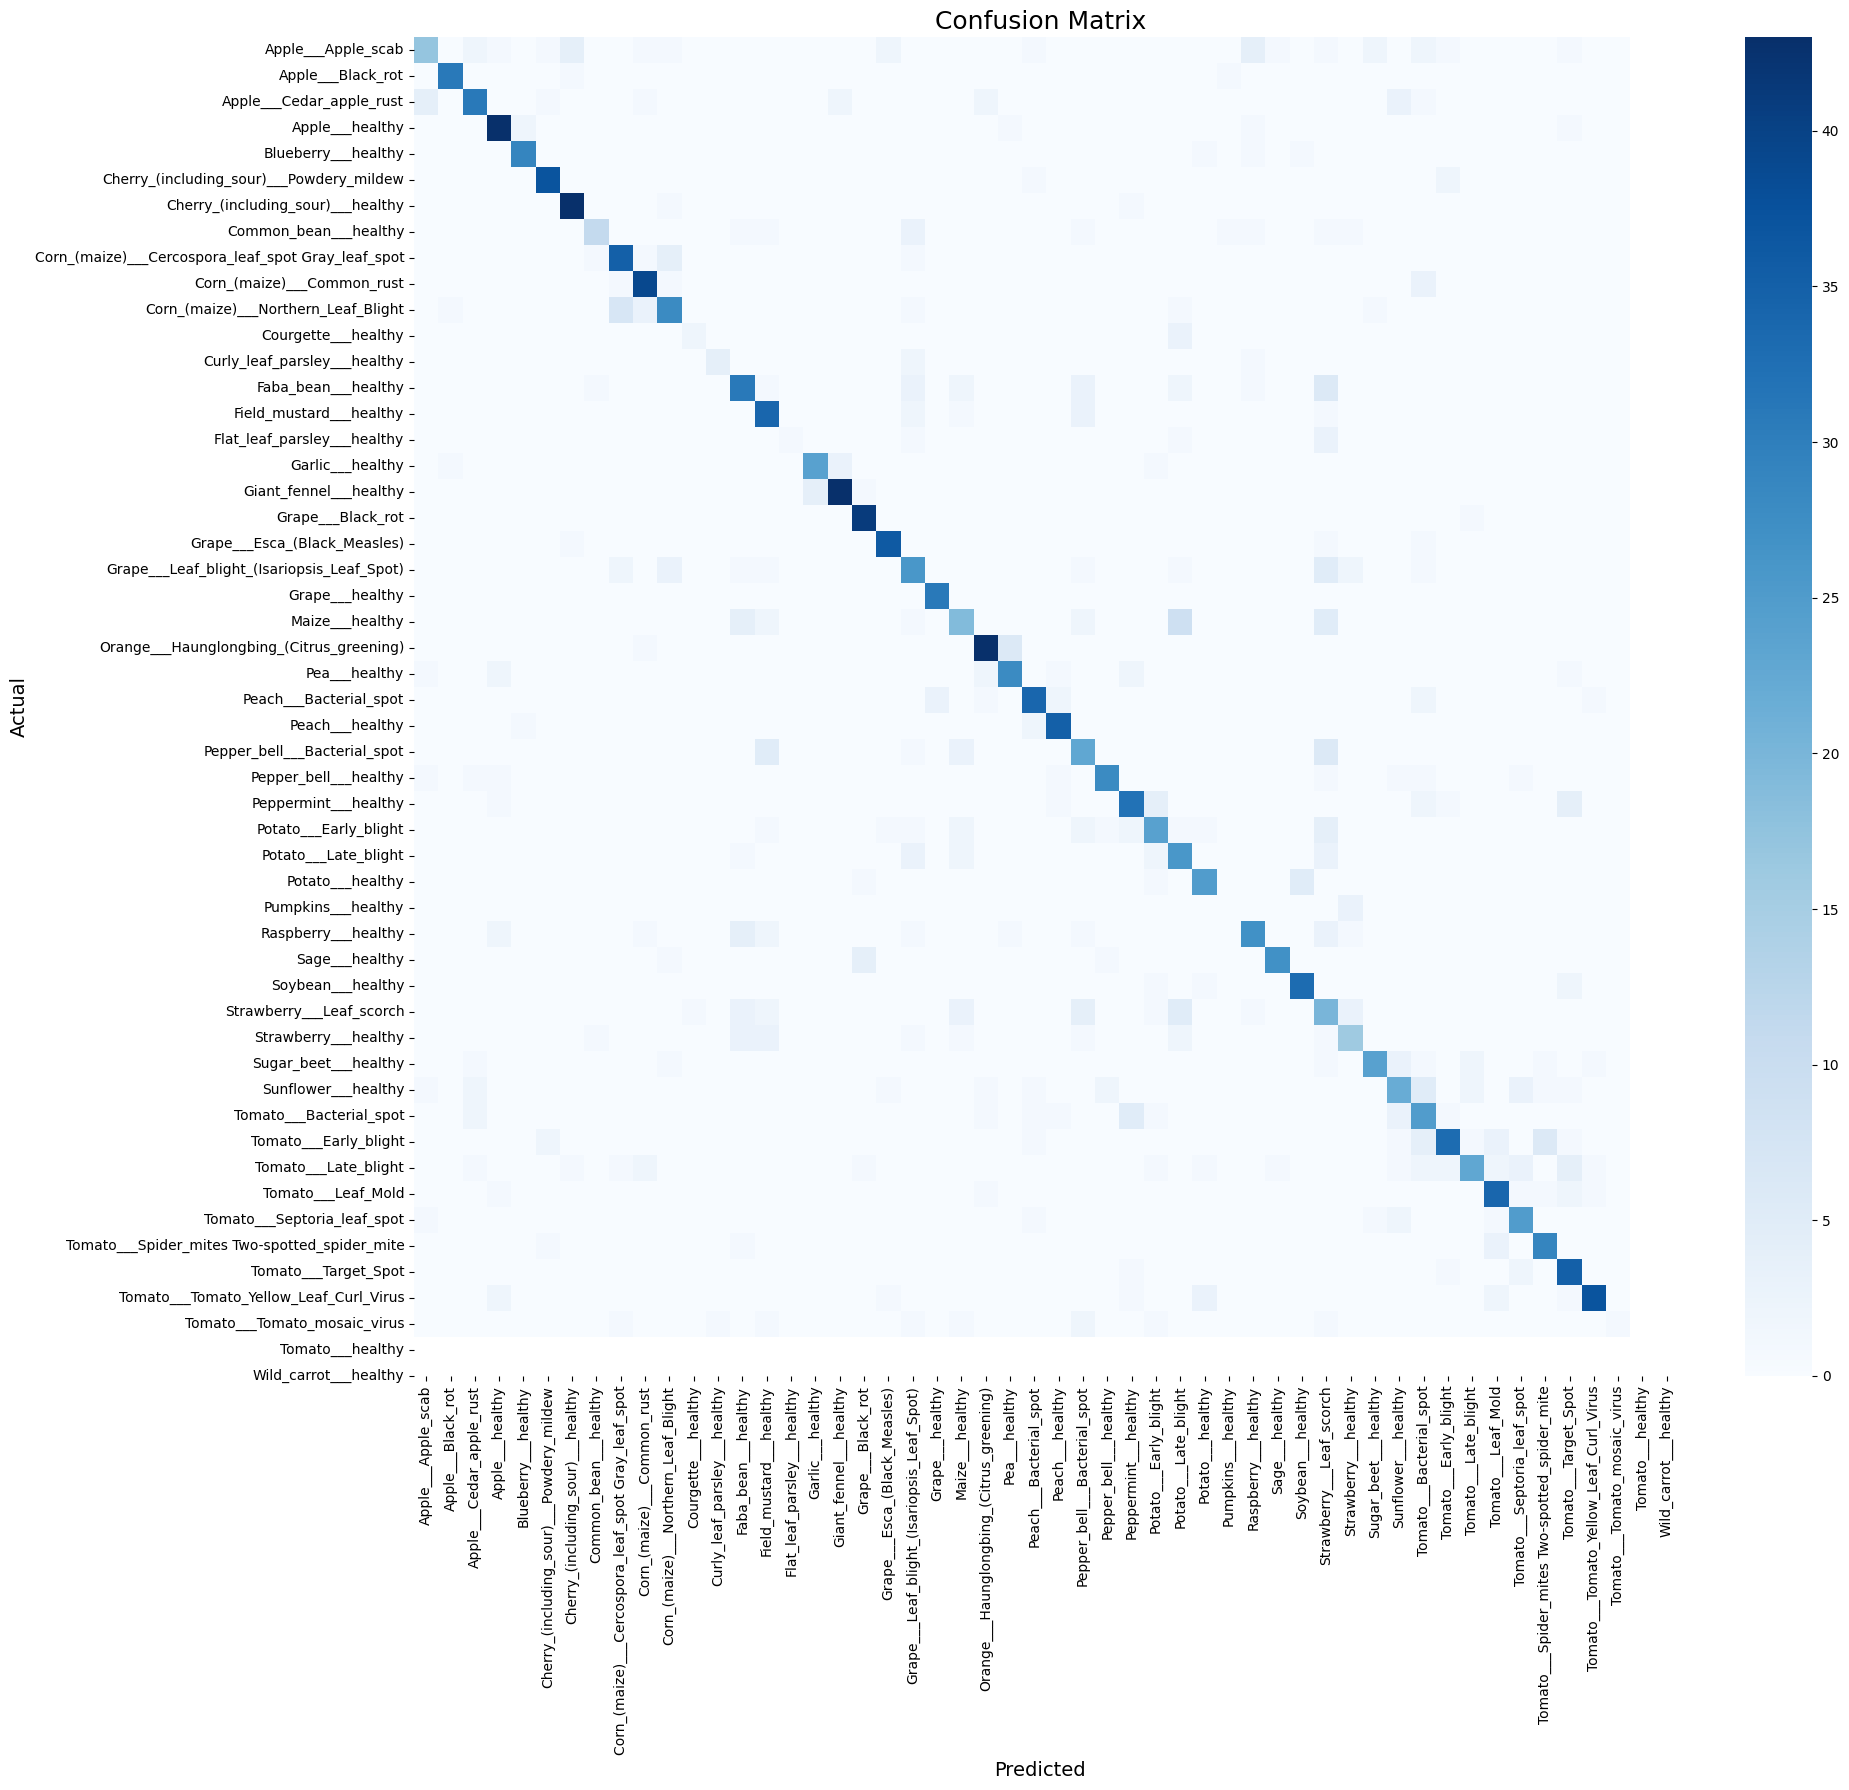

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(20, 18))
sns.heatmap(cm, xticklabels=class_names, yticklabels=class_names, cmap="Blues", fmt='g')
plt.title("Confusion Matrix", fontsize=18)
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("Actual", fontsize=14)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


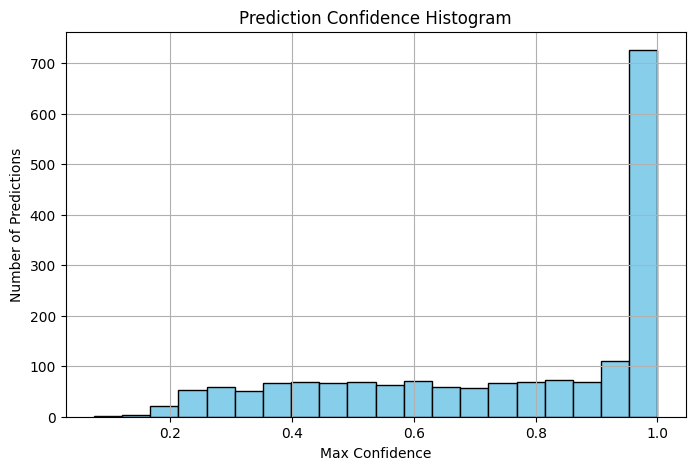

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Get prediction confidences (max softmax probability)
confidences = []

for batch in test_ds:
    images, labels = batch
    preds = model.predict(images, verbose=0)
    confidences.extend(np.max(preds, axis=1))  # highest softmax score per sample

plt.figure(figsize=(8, 5))
plt.hist(confidences, bins=20, color='skyblue', edgecolor='black')
plt.title("Prediction Confidence Histogram")
plt.xlabel("Max Confidence")
plt.ylabel("Number of Predictions")
plt.grid(True)
plt.show()


In [16]:
import pandas as pd

# Get class names from indices
def get_label(idx):
    return class_names[idx]

wrong_preds = []

for batch in test_ds:
    images, labels = batch
    preds = model.predict(images, verbose=0)
    pred_labels = np.argmax(preds, axis=1)
    for i in range(len(labels)):
        true = labels[i].numpy()
        pred = pred_labels[i]
        if true != pred:
            wrong_preds.append({
                'True Label': get_label(true),
                'Predicted Label': get_label(pred),
                'Confidence': float(np.max(preds[i]))
            })

# Convert to DataFrame
df_wrong = pd.DataFrame(wrong_preds)

# Preview
from IPython.display import display
display(df_wrong.head(10))

# Save to CSV
df_wrong.to_csv("wrong_predictions.csv", index=False)
print("✅ Exported to wrong_predictions.csv")


True Label                         Predicted Label  \
0           Tomato___Leaf_Mold                    Tomato___Late_blight   
1      Tomato___Bacterial_spot                        Tomato___healthy   
2           Apple___Apple_scab                Apple___Cedar_apple_rust   
3           Tomato___Leaf_Mold  Tomato___Tomato_Yellow_Leaf_Curl_Virus   
4     Strawberry___Leaf_scorch     Corn_(maize)___Northern_Leaf_Blight   
5  Tomato___Septoria_leaf_spot                Strawberry___Leaf_scorch   
6              Maize___healthy                    Sugar_beet___healthy   
7            Soybean___healthy                    Sugar_beet___healthy   
8  Tomato___Septoria_leaf_spot                        Tomato___healthy   
9          Sunflower___healthy                           Pea___healthy   

   Confidence  
0    0.564565  
1    0.607278  
2    0.511751  
3    0.566187  
4    0.710219  
5    0.874683  
6    0.425860  
7    0.410188  
8    0.710733  
9    0.271646

✅ Exported to wrong_predictions.csv


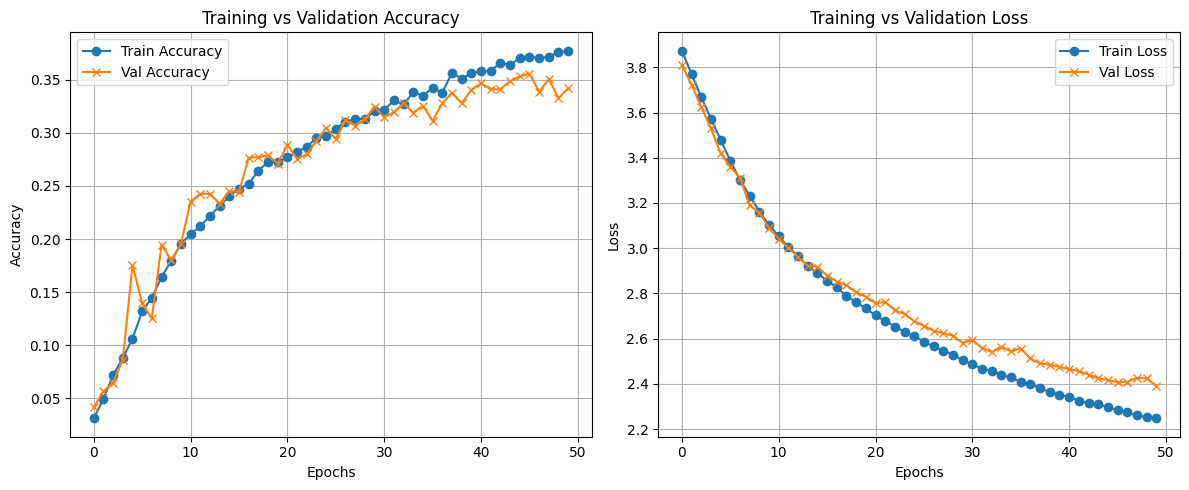

In [69]:
# === 9. Plot Accuracy and Loss ===
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='x')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.grid(True)
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='x')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
model.save("/content/drive/MyDrive/UOA_Capstone/PD_PV_CAW_Model/resnet50_finetuned_52class.keras")


In [21]:
from tensorflow import keras
model = keras.models.load_model("/content/drive/MyDrive/UOA_Capstone/PD_PV_CAW_Model/resnet50_finetuned_52class_vfinal.keras")

#model.load("/content/drive/MyDrive/UOA_Capstone/PD_PV_CAW_Model/resnet50_finetuned_52class_vfinal.keras")

In [22]:
import tensorflow as tf

# Set your dataset directory
DATASET_DIR = "/content/kaggle_dataset_cw_enriched_v4/processed_crops_v2"

# Load a temporary dataset to extract class names
tmp_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_DIR,
    image_size=(224, 224),
    batch_size=32,
    shuffle=False  # keep consistent class-to-index mapping
)

# Extract class names
class_names = tmp_ds.class_names
del tmp_ds  # free memory

# Print class list
print("Number of classes:", len(class_names))
print("Class names:")
for i, name in enumerate(class_names):
    print(f"{i:2d}: {name}")


Found 9095 files belonging to 52 classes.
Number of classes: 52
Class names:
 0: Apple___Apple_scab
 1: Apple___Black_rot
 2: Apple___Cedar_apple_rust
 3: Apple___healthy
 4: Blueberry___healthy
 5: Cherry_(including_sour)___Powdery_mildew
 6: Cherry_(including_sour)___healthy
 7: Common_bean___healthy
 8: Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
 9: Corn_(maize)___Common_rust
10: Corn_(maize)___Northern_Leaf_Blight
11: Courgette___healthy
12: Curly_leaf_parsley___healthy
13: Faba_bean___healthy
14: Field_mustard___healthy
15: Flat_leaf_parsley___healthy
16: Garlic___healthy
17: Giant_fennel___healthy
18: Grape___Black_rot
19: Grape___Esca_(Black_Measles)
20: Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
21: Grape___healthy
22: Maize___healthy
23: Orange___Haunglongbing_(Citrus_greening)
24: Pea___healthy
25: Peach___Bacterial_spot
26: Peach___healthy
27: Pepper_bell___Bacterial_spot
28: Pepper_bell___healthy
29: Peppermint___healthy
30: Potato___Early_blight
31: Potato___Late_b

In [23]:
# Load class names from dataset folder (must be same used during training)
import tensorflow as tf

DATASET_DIR = "/content/kaggle_dataset_cw_enriched_v4/processed_crops_v2"

tmp_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_DIR,
    image_size=(224, 224),
    batch_size=32,
    shuffle=False
)

class_names = tmp_ds.class_names
del tmp_ds


Found 9095 files belonging to 52 classes.


In [ ]:
class_names

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Blueberry___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Cherry_(including_sour)___healthy',
 'Common_bean___healthy',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Courgette___healthy',
 'Curly_leaf_parsley___healthy',
 'Faba_bean___healthy',
 'Field_mustard___healthy',
 'Flat_leaf_parsley___healthy',
 'Garlic___healthy',
 'Giant_fennel___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Maize___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Pea___healthy',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper_bell___Bacterial_spot',
 'Pepper_bell___healthy',
 'Peppermint___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Pumpkins___healthy',
 'Raspberry___healthy',
 'S

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


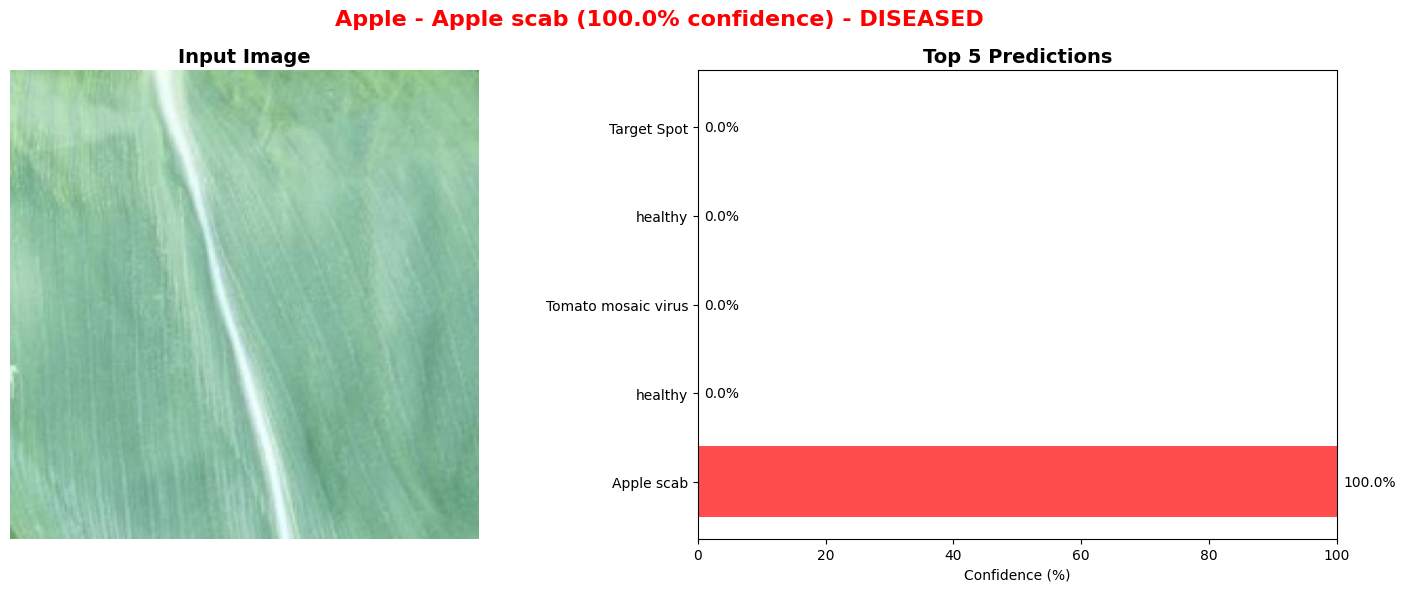

🌱 PLANT DISEASE CLASSIFICATION RESULTS 🌱
🎯 Primary Prediction:
   Plant Type: Apple
   Condition: Apple_scab
   Health Status: ⚠️ Diseased
   Confidence: 100.0%

📊 Top 5 Possibilities:
   1. ⚠️ Apple - Apple_scab (100.0%)
   2. ✅ Wild_carrot - healthy (0.0%)
   3. ⚠️ Tomato - Tomato_mosaic_virus (0.0%)
   4. ✅ Tomato - healthy (0.0%)
   5. ⚠️ Tomato - Target_Spot (0.0%)

💡 Interpretation Guide:
   🟢 High confidence - Very reliable prediction

🚨 Disease Detected: Apple_scab


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from PIL import Image

# Class names for the 38 categories (based on the PlantVillage dataset structure)
# class_names = [
# 'Apple___Apple_scab',
# 'Apple___Black_rot',
# 'Apple___Cedar_apple_rust',
# 'Apple___healthy',
# 'Blueberry___healthy',
# 'Cherry_(including_sour)___Powdery_mildew',
# 'Cherry_(including_sour)___healthy',
# 'Common_bean___healthy',
# 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
# 'Corn_(maize)___Common_rust',
# 'Corn_(maize)___Northern_Leaf_Blight',
# 'Courgette___healthy',
# 'Curly_leaf_parsley___healthy',
# 'Faba_bean___healthy',
# 'Field_mustard___healthy',
# 'Flat_leaf_parsley___healthy',
# 'Garlic___healthy',
# 'Giant_fennel___healthy',
# 'Grape___Black_rot',
# 'Grape___Esca_(Black_Measles)',
# 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
# 'Grape___healthy',
# 'Maize___healthy',
# 'Orange___Haunglongbing_(Citrus_greening)',
# 'Pea___healthy',
# 'Peach___Bacterial_spot',
# 'Peach___healthy',
# 'Pepper_bell___Bacterial_spot',
# 'Pepper_bell___healthy',
# 'Peppermint___healthy',
# 'Potato___Early_blight',
# 'Potato___Late_blight',
# 'Potato___healthy',
# 'Pumpkins___healthy',
# 'Raspberry___healthy',
# 'Sage___healthy',
# 'Soybean___healthy',
# 'Strawberry___Leaf_scorch',
# 'Strawberry___healthy',
# 'Sugar_beet___healthy',
# 'Sunflower___healthy',
# 'Tomato___Bacterial_spot',
# 'Tomato___Early_blight',
# 'Tomato___Late_blight',
# 'Tomato___Leaf_Mold',
# 'Tomato___Septoria_leaf_spot',
# 'Tomato___Spider_mites Two-spotted_spider_mite',
# 'Tomato___Target_Spot',
# 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
# 'Tomato___Tomato_mosaic_virus',
# 'Tomato___healthy',
# 'Wild_carrot___healthy'
# ]

def interpret_prediction(model, image_path):
    """
    Interpret plant disease prediction results

    Args:
        model: Trained keras model
        image_path: Path to the input image

    Returns:
        Dictionary with interpretation results
    """

    # Load and preprocess image
    img = keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Get predictions
    predictions = model.predict(img_array)
    probabilities = predictions[0]  # Remove batch dimension

    # Get top 5 predictions
    top_indices = np.argsort(probabilities)[::-1][:5]
    top_probabilities = probabilities[top_indices]
    top_classes = [class_names[i] for i in top_indices]

    # Parse the top prediction
    predicted_class = top_classes[0]
    confidence = top_probabilities[0]

    # Extract plant type and condition
    plant_type = predicted_class.split('___')[0]
    condition = predicted_class.split('___')[1]

    # Determine if healthy or diseased
    is_healthy = 'healthy' in condition.lower()

    results = {
        'predicted_class': predicted_class,
        'plant_type': plant_type,
        'condition': condition,
        'is_healthy': is_healthy,
        'confidence': confidence,
        'confidence_percentage': confidence * 100,
        'top_5_predictions': [
            {
                'class': cls,
                'plant': cls.split('___')[0],
                'condition': cls.split('___')[1],
                'probability': prob,
                'percentage': prob * 100
            }
            for cls, prob in zip(top_classes, top_probabilities)
        ]
    }

    return results



def visualize_prediction(model, image_path, show_image=True):
    """
    Visualize plant disease prediction with image display

    Args:
        model: Trained keras model
        image_path: Path to the input image
        show_image: Whether to display the image
    """

    # Get prediction results
    results = interpret_prediction(model, image_path)

    if show_image:
        # Load and display the image
        img = Image.open(image_path)

        # Create figure with subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # Display original image
        ax1.imshow(img)
        ax1.set_title('Input Image', fontsize=14, fontweight='bold')
        ax1.axis('off')

        # Display prediction results as a bar chart
        top_5_classes = [pred['condition'] for pred in results['top_5_predictions']]
        top_5_probs = [pred['percentage'] for pred in results['top_5_predictions']]

        colors = ['red' if 'healthy' not in cls.lower() else 'green' for cls in top_5_classes]
        bars = ax2.barh(range(len(top_5_classes)), top_5_probs, color=colors, alpha=0.7)

        ax2.set_yticks(range(len(top_5_classes)))
        ax2.set_yticklabels([cls.replace('_', ' ') for cls in top_5_classes])
        ax2.set_xlabel('Confidence (%)')
        ax2.set_title('Top 5 Predictions', fontsize=14, fontweight='bold')
        ax2.set_xlim(0, 100)

        # Add percentage labels on bars
        for i, (bar, prob) in enumerate(zip(bars, top_5_probs)):
            ax2.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
                    f'{prob:.1f}%', va='center', fontsize=10)

        # Add main prediction as title
        plant_type = results['plant_type']
        condition = results['condition'].replace('_', ' ')
        confidence = results['confidence_percentage']
        status = "HEALTHY" if results['is_healthy'] else "DISEASED"

        fig.suptitle(f'{plant_type} - {condition} ({confidence:.1f}% confidence) - {status}',
                    fontsize=16, fontweight='bold',
                    color='green' if results['is_healthy'] else 'red')

        plt.tight_layout()
        plt.show()

    return results




def print_interpretation(results):
    """
    Print human-readable interpretation of results
    """
    print("🌱 PLANT DISEASE CLASSIFICATION RESULTS 🌱")
    print("=" * 50)

    print(f"🎯 Primary Prediction:")
    print(f"   Plant Type: {results['plant_type']}")
    print(f"   Condition: {results['condition']}")
    print(f"   Health Status: {'✅ Healthy' if results['is_healthy'] else '⚠️ Diseased'}")
    print(f"   Confidence: {results['confidence_percentage']:.1f}%")

    print(f"\n📊 Top 5 Possibilities:")
    for i, pred in enumerate(results['top_5_predictions'], 1):
        status = "✅" if 'healthy' in pred['condition'].lower() else "⚠️"
        print(f"   {i}. {status} {pred['plant']} - {pred['condition']} ({pred['percentage']:.1f}%)")

    print(f"\n💡 Interpretation Guide:")
    if results['confidence_percentage'] > 80:
        print("   🟢 High confidence - Very reliable prediction")
    elif results['confidence_percentage'] > 60:
        print("   🟡 Moderate confidence - Fairly reliable prediction")
    else:
        print("   🔴 Low confidence - Consider additional verification")

    if not results['is_healthy']:
        print(f"\n🚨 Disease Detected: {results['condition']}")
        # This is not part of model, I have added it for comleteness
        # print("   Recommended actions:")
        # print("   - Consult with agricultural expert")
        # print("   - Consider appropriate treatment measures")
        # print("   - Monitor other plants for similar symptoms")



# If you want to test with a batch of images:
def batch_predict(model, image_paths):
    """
    Predict multiple images at once
    """
    results = []
    for img_path in image_paths:
        result = interpret_prediction(model, img_path)
        results.append(result)
    return results

from tensorflow.keras.models import load_model
model = load_model("/content/resnet50_finetuned_52class.keras")
results = visualize_prediction(model, '/content/kaggle_dataset_cw_enriched_v4/processed_crops_v2/Maize___healthy/16123a33-12e5-414e-9ae0-695b86e6cb3a___R.S_HL 8136 copy.jpg')
#results = interpret_prediction(model, '/content/kaggle_dataset/Cherry_(including_sour)___Powdery_mildew/00705aa7-5ea2-4419-9440-8ba65e108eb9___FREC_Pwd.M 0267.JPG')
print_interpretation(results)


In [25]:
img = keras.preprocessing.image.load_img('/content/kaggle_dataset_cw_enriched_v4/processed_crops_v2/Sunflower___healthy/ave-0051-0005_4.jpg', target_size=(224, 224))
img_array = keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array / 255.0, axis=0)

predictions = model.predict(img_array)
pred_idx = np.argmax(predictions)
print(f"Predicted index: {pred_idx}")
print(f"Mapped label: {class_names[pred_idx]}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted index: 40
Mapped label: Sunflower___healthy


In [28]:
model = load_model("/content/drive/MyDrive/UOA_Capstone/PD_PV_CAW_Model/resnet50_finetuned_52class_vfinal.keras")

Found 9095 files belonging to 52 classes.


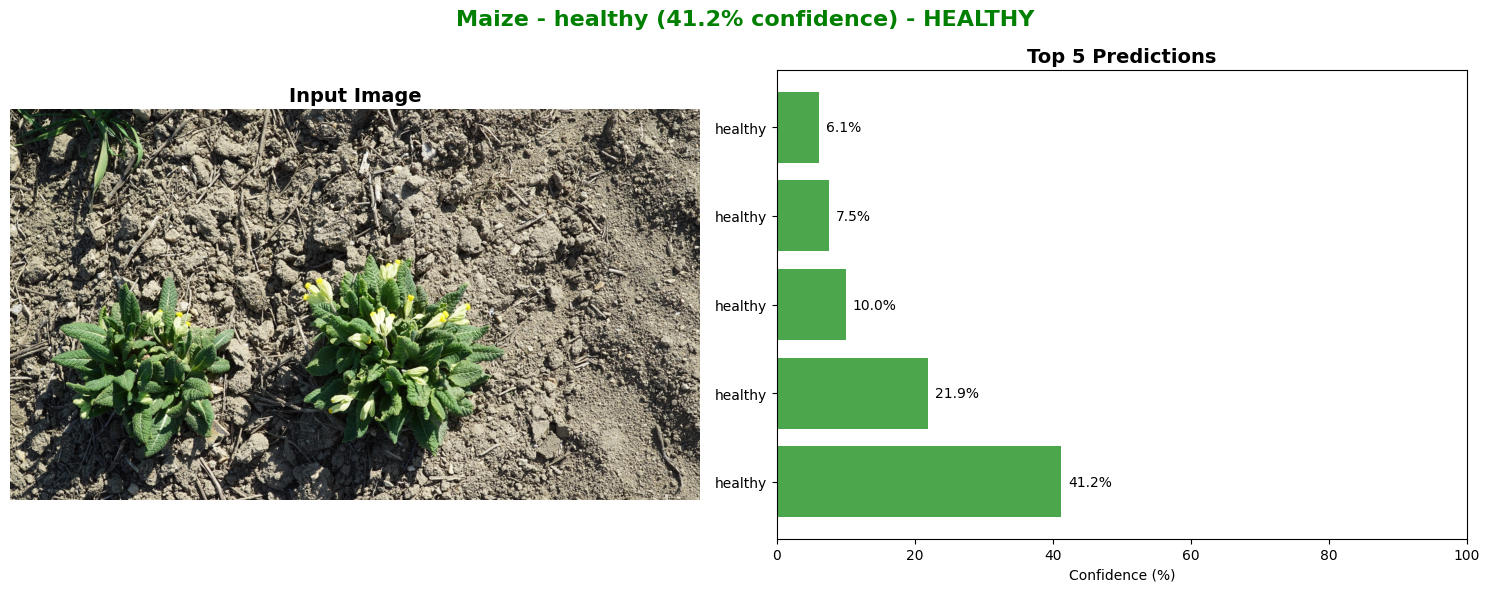

🌱 PLANT DISEASE CLASSIFICATION RESULTS 🌱
🎯 Primary Prediction:
   Plant Type: Maize
   Condition: healthy
   Health Status: ✅ Healthy
   Confidence: 41.2%

📊 Top 5 Possibilities:
   1. ✅ Maize - healthy (41.2%)
   2. ✅ Pumpkins - healthy (21.9%)
   3. ✅ Pea - healthy (10.0%)
   4. ✅ Sunflower - healthy (7.5%)
   5. ✅ Sugar_beet - healthy (6.1%)

💡 Interpretation Guide:
   🔴 Low confidence - Consider additional verification


In [29]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from PIL import Image
import matplotlib.pyplot as plt

# === Automatically load class names ===
def load_class_names(data_dir):
    ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        image_size=(224, 224),
        batch_size=1,
        shuffle=False
    )
    class_names = ds.class_names
    del ds
    return class_names

# === Global variables ===
DATASET_DIR = "/content/kaggle_dataset_cw_enriched_v4/processed_crops_v2"
class_names = load_class_names(DATASET_DIR)

# === Interpret prediction ===
def interpret_prediction(model, image_path):
    img = keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array / 255.0, axis=0)  # Normalize

    predictions = model.predict(img_array, verbose=0)
    probabilities = predictions[0]

    top_indices = np.argsort(probabilities)[::-1][:5]
    top_probabilities = probabilities[top_indices]
    top_classes = [class_names[i] for i in top_indices]

    predicted_class = top_classes[0]
    confidence = top_probabilities[0]
    plant_type = predicted_class.split('___')[0]
    condition = predicted_class.split('___')[1] if '___' in predicted_class else 'unknown'
    is_healthy = 'healthy' in condition.lower()

    results = {
        'predicted_class': predicted_class,
        'plant_type': plant_type,
        'condition': condition,
        'is_healthy': is_healthy,
        'confidence': confidence,
        'confidence_percentage': confidence * 100,
        'top_5_predictions': [
            {
                'class': cls,
                'plant': cls.split('___')[0],
                'condition': cls.split('___')[1] if '___' in cls else 'unknown',
                'probability': prob,
                'percentage': prob * 100
            }
            for cls, prob in zip(top_classes, top_probabilities)
        ]
    }

    return results

# === Visualize prediction ===
def visualize_prediction(model, image_path, show_image=True):
    results = interpret_prediction(model, image_path)

    if show_image:
        img = Image.open(image_path)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        ax1.imshow(img)
        ax1.set_title('Input Image', fontsize=14, fontweight='bold')
        ax1.axis('off')

        top_5_classes = [pred['condition'] for pred in results['top_5_predictions']]
        top_5_probs = [pred['percentage'] for pred in results['top_5_predictions']]

        colors = ['green' if 'healthy' in cls.lower() else 'red' for cls in top_5_classes]
        bars = ax2.barh(range(len(top_5_classes)), top_5_probs, color=colors, alpha=0.7)

        ax2.set_yticks(range(len(top_5_classes)))
        ax2.set_yticklabels([cls.replace('_', ' ') for cls in top_5_classes])
        ax2.set_xlabel('Confidence (%)')
        ax2.set_title('Top 5 Predictions', fontsize=14, fontweight='bold')
        ax2.set_xlim(0, 100)

        for i, (bar, prob) in enumerate(zip(bars, top_5_probs)):
            ax2.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
                     f'{prob:.1f}%', va='center', fontsize=10)

        plant_type = results['plant_type']
        condition = results['condition'].replace('_', ' ')
        confidence = results['confidence_percentage']
        status = "HEALTHY" if results['is_healthy'] else "DISEASED"

        fig.suptitle(
            f'{plant_type} - {condition} ({confidence:.1f}% confidence) - {status}',
            fontsize=16, fontweight='bold',
            color='green' if results['is_healthy'] else 'red'
        )

        plt.tight_layout()
        plt.show()

    return results

# === Print interpretation ===
def print_interpretation(results):
    print("🌱 PLANT DISEASE CLASSIFICATION RESULTS 🌱")
    print("=" * 50)

    print(f"🎯 Primary Prediction:")
    print(f"   Plant Type: {results['plant_type']}")
    print(f"   Condition: {results['condition']}")
    print(f"   Health Status: {'✅ Healthy' if results['is_healthy'] else '⚠️ Diseased'}")
    print(f"   Confidence: {results['confidence_percentage']:.1f}%")

    print(f"\n📊 Top 5 Possibilities:")
    for i, pred in enumerate(results['top_5_predictions'], 1):
        status = "✅" if 'healthy' in pred['condition'].lower() else "⚠️"
        print(f"   {i}. {status} {pred['plant']} - {pred['condition']} ({pred['percentage']:.1f}%)")

    print(f"\n💡 Interpretation Guide:")
    if results['confidence_percentage'] > 80:
        print("   🟢 High confidence - Very reliable prediction")
    elif results['confidence_percentage'] > 60:
        print("   🟡 Moderate confidence - Fairly reliable prediction")
    else:
        print("   🔴 Low confidence - Consider additional verification")

    if not results['is_healthy']:
        print(f"\n🚨 Disease Detected: {results['condition']}")

# === Batch prediction utility ===
def batch_predict(model, image_paths):
    results = []
    for img_path in image_paths:
        result = interpret_prediction(model, img_path)
        results.append(result)
    return results

# === Load model and test ===
from tensorflow.keras.models import load_model
#model = keras.models.load_model("/content/drive/MyDrive/UOA_Capstone/PD_PV_CAW_Model/resnet50_finetuned_52class_vfinal.keras")
#model = load_model("/content/drive/MyDrive/UOA_Capstone/PD_PV_CAW_Model/resnet50_finetuned_52class_vfinal.keras")

#test_image = "/content/kaggle_dataset_cw_enriched_v4/processed_crops_v2/Potato___Late_blight/00695906-210d-4a9d-822e-986a17384115___RS_LB 4026.jpg"
test_image = "/content/drive/MyDrive/crop_and_weed/images/ave-0035-0002.jpg"
results = visualize_prediction(model, test_image)
print_interpretation(results)


In [33]:
 def rand_conf() -> float:
  return round(random.uniform(60, 95), 1)

Found 9095 files belonging to 52 classes.


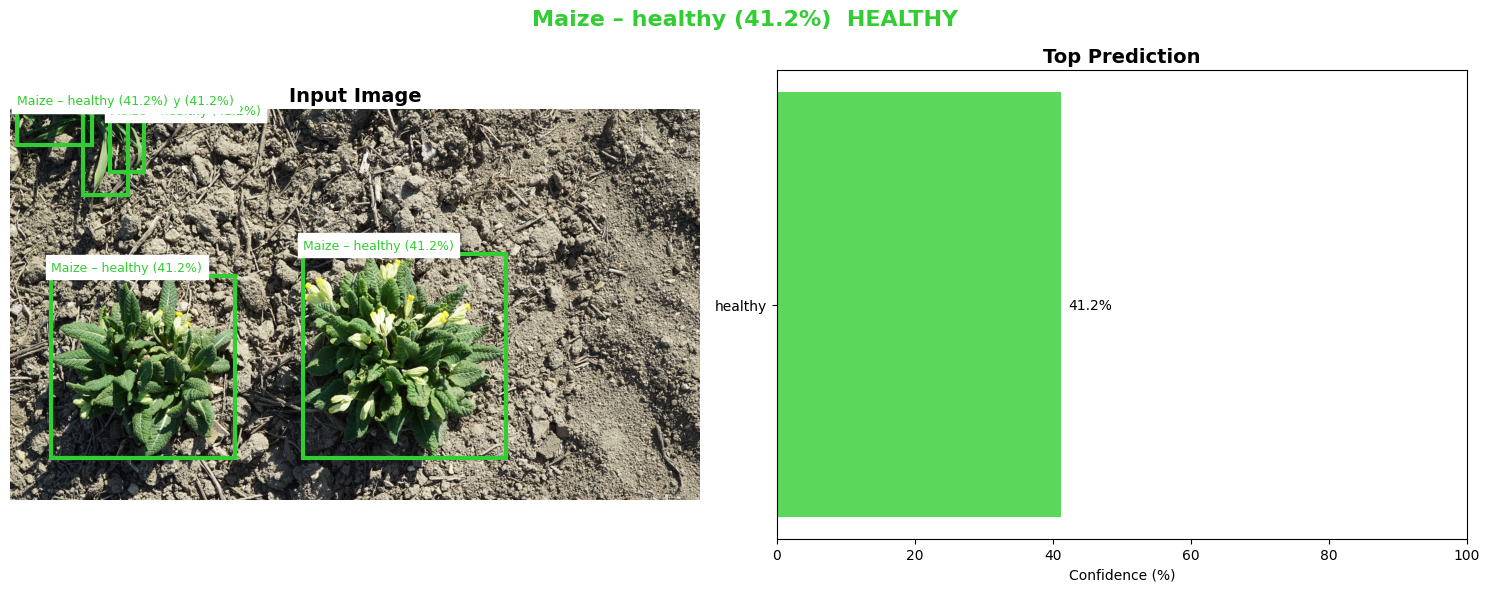

In [30]:
"""
Crop-and-Weed: adaptive bbox + label overlay
-------------------------------------------
• Two-stage detector:
    1. Green HSV mask (tunable)
    2. If too few green pixels → use edge density
• Puts label text on the bounding box
• Sensitivity knobs:
      GREEN_THRESH (0–255)  – lower → more tolerant green
      EDGE_THRESH  (0–1)    – lower → easier to trigger edge boxes
"""

# ============== 0. user-tunable knobs ==============
GREEN_THRESH = 30      # bigger hits only vivid green, lower grabs pale plants
EDGE_THRESH  = 0.10    # fraction of img area that must be edge-active to accept

# ============== 1. imports & paths =================
import os, cv2, numpy as np, tensorflow as tf
from tensorflow import keras
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

DATASET_DIR = "/content/kaggle_dataset_cw_enriched_v4/processed_crops_v2"
MODEL_PATH  = ("/content/drive/MyDrive/UOA_Capstone/PD_PV_CAW_Model/"
               "resnet50_finetuned_52class_vfinal.keras")

def load_class_names(d):
    ds = tf.keras.utils.image_dataset_from_directory(
        d, image_size=(224, 224), batch_size=1, shuffle=False
    )
    names = ds.class_names
    del ds
    return names

CLASS_NAMES = load_class_names(DATASET_DIR)
MODEL       = keras.models.load_model(MODEL_PATH)


# ============== 2. adaptive bbox finder =============
def detect_green_boxes(img_bgr, min_area_frac=0.001, green_thresh=GREEN_THRESH):
    """
    Stage-1: green mask
    """
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    lower = (25, green_thresh, green_thresh)      # H,S,V lower bounds
    upper = (90, 255, 255)
    mask  = cv2.inRange(hsv, lower, upper)
    mask  = cv2.morphologyEx(mask, cv2.MORPH_OPEN,
                             cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)))
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL,
                                   cv2.CHAIN_APPROX_SIMPLE)
    H, W = mask.shape
    min_area = min_area_frac * H * W
    boxes = []
    for c in contours:
        if cv2.contourArea(c) < min_area:
            continue
        x, y, w, h = cv2.boundingRect(c)
        boxes.append((x, y, x + w, y + h))
    return boxes


def detect_edge_boxes(img_bgr, min_area_frac=0.002, edge_thresh=EDGE_THRESH):
    """
    Stage-2 fallback: Canny edges + dilation + connected components
    """
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 80, 160)
    edges = cv2.dilate(edges, None, iterations=2)

    num_edge_px = np.count_nonzero(edges)
    if num_edge_px / edges.size < edge_thresh:
        return []  # very flat = likely blank soil, skip

    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL,
                                   cv2.CHAIN_APPROX_SIMPLE)
    H, W = edges.shape
    min_area = min_area_frac * H * W
    boxes = []
    for c in contours:
        if cv2.contourArea(c) < min_area:
            continue
        x, y, w, h = cv2.boundingRect(c)
        boxes.append((x, y, x + w, y + h))
    return boxes


def dynamic_bboxes(pil_img):
    """
    Hybrid detector that returns list[(x1,y1,x2,y2)].
    """
    img_bgr = cv2.cvtColor(np.array(pil_img), cv2.COLOR_RGB2BGR)

    boxes = detect_green_boxes(img_bgr)
    if not boxes:                       # fallback if green failed
        boxes = detect_edge_boxes(img_bgr)

    return boxes


# ============== 3. prediction helper ================
def interpret_prediction(img_path):
    img = keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    arr = keras.preprocessing.image.img_to_array(img) / 255.0
    probs = MODEL.predict(arr[np.newaxis, ...], verbose=0)[0]
    idx   = int(np.argmax(probs))

    plant, _, cond = CLASS_NAMES[idx].partition("___")
    cond = cond or "unknown"
    return {
        "plant": plant,
        "cond": cond,
        "healthy": "healthy" in cond.lower(),
        "pct": probs[idx] * 100
    }


# ============== 4. visualiser =======================
def show(img_path):
    meta = interpret_prediction(img_path)
    pil  = Image.open(img_path)
    bboxes = dynamic_bboxes(pil)

    colour = "limegreen" if meta["healthy"] else "orangered"
    label  = f"{meta['plant']} – {meta['cond']} ({meta['pct']:.1f}%)"

    fig, (axI, axB) = plt.subplots(1, 2, figsize=(15, 6))

    # --- image ---
    axI.imshow(pil)
    axI.set_title("Input Image", fontsize=14, fontweight="bold")
    axI.axis("off")

    # ensure at least one box
    if not bboxes:
        bboxes = [(0, 0, pil.width, pil.height)]

    for (x1, y1, x2, y2) in bboxes:
        axI.add_patch(Rectangle((x1, y1), x2-x1, y2-y1,
                                edgecolor=colour, linewidth=3,
                                facecolor="none"))
        axI.text(x1, y1-5, label, color=colour, fontsize=9,
                 va="bottom", ha="left", backgroundcolor="white")

    # --- bar ---
    axB.barh([0], [meta["pct"]], color=colour, alpha=0.8)
    axB.set_yticks([0])
    axB.set_yticklabels([meta["cond"].replace('_', ' ')])
    axB.set_xlim(0, 100)
    axB.set_xlabel("Confidence (%)")
    axB.invert_yaxis()
    for bar in axB.patches:
        axB.text(bar.get_width()+1, bar.get_y()+bar.get_height()/2,
                 f"{bar.get_width():.1f}%", va="center")
    axB.set_title("Top Prediction", fontsize=14, fontweight="bold")

    fig.suptitle(label + ("  HEALTHY" if meta["healthy"] else "  DISEASED"),
                 fontsize=16, fontweight="bold", color=colour)
    plt.tight_layout()
    plt.show()


# ============== 5. quick demo =======================
if __name__ == "__main__":
    TEST = "/content/drive/MyDrive/crop_and_weed/images/ave-0035-0002.jpg"
    show(TEST)


Found 9095 files belonging to 52 classes.


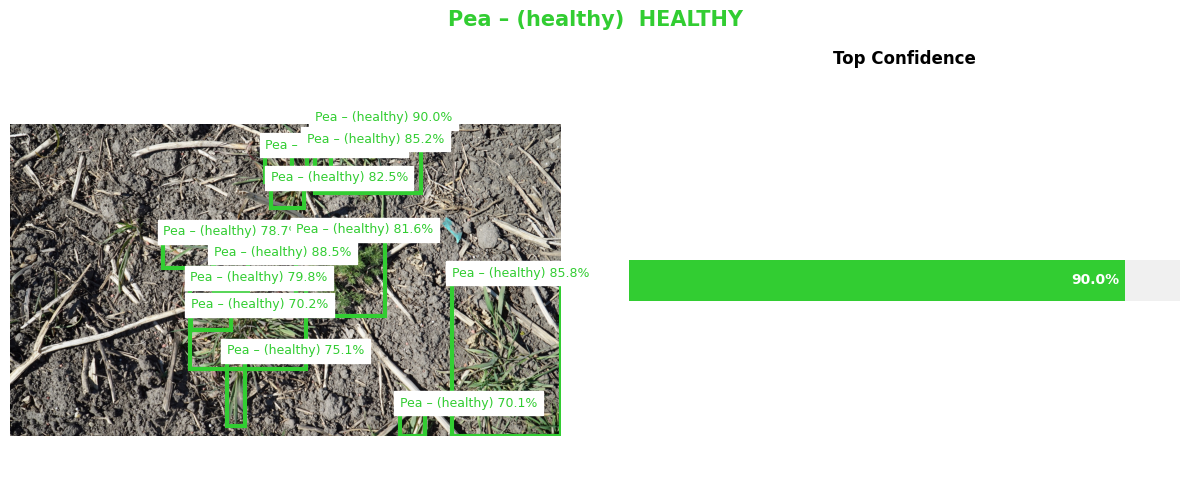

In [68]:
"""
Crop-and-Weed visualiser
------------------------
• Adaptive green/edge bbox detector
• Image-level classification (top-1)
• Compact progress-bar showing confidence
"""

# ============== 0. user-tunable knobs ==============
GREEN_THRESH = 30     # ↓ to grab paler plants, ↑ to ignore them
EDGE_THRESH  = 0.10   # ↓ easier edge fallback trigger, ↑ stricter

# ============== 1. imports & paths =================
import os, cv2, numpy as np, tensorflow as tf
from tensorflow import keras
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

DATASET_DIR = "/content/kaggle_dataset_cw_enriched_v4/processed_crops_v2"
MODEL_PATH  = ("/content/drive/MyDrive/UOA_Capstone/PD_PV_CAW_Model/resnet50_finetuned_52class_vfinal.keras")


# ============== 2. class names & model =============
def load_class_names(d):
    ds = tf.keras.utils.image_dataset_from_directory(
        d, image_size=(224, 224), batch_size=1, shuffle=False
    )
    names = ds.class_names
    del ds
    return names

CLASS_NAMES = load_class_names(DATASET_DIR)
MODEL       = keras.models.load_model(MODEL_PATH)


# ============== 3. adaptive bbox finder =============
def detect_green_boxes(img_bgr, min_area_frac=0.001, green_thresh=GREEN_THRESH):
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    lower = (25, green_thresh, green_thresh)
    upper = (90, 255, 255)
    mask  = cv2.inRange(hsv, lower, upper)
    mask  = cv2.morphologyEx(
        mask, cv2.MORPH_OPEN,
        cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    )
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL,
                                   cv2.CHAIN_APPROX_SIMPLE)
    H, W = mask.shape
    min_area = min_area_frac * H * W
    boxes = [
        (x, y, x + w, y + h)
        for c in contours if cv2.contourArea(c) >= min_area
        for (x, y, w, h) in [cv2.boundingRect(c)]
    ]
    return boxes


def detect_edge_boxes(img_bgr, min_area_frac=0.002, edge_thresh=EDGE_THRESH):
    gray  = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 80, 160)
    edges = cv2.dilate(edges, None, iterations=2)

    if np.count_nonzero(edges) / edges.size < edge_thresh:
        return []

    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL,
                                   cv2.CHAIN_APPROX_SIMPLE)
    H, W = edges.shape
    min_area = min_area_frac * H * W
    boxes = [
        (x, y, x + w, y + h)
        for c in contours if cv2.contourArea(c) >= min_area
        for (x, y, w, h) in [cv2.boundingRect(c)]
    ]
    return boxes


def dynamic_bboxes(pil_img):
    img_bgr = cv2.cvtColor(np.array(pil_img), cv2.COLOR_RGB2BGR)
    boxes = detect_green_boxes(img_bgr)
    if not boxes:
        boxes = detect_edge_boxes(img_bgr)
    return boxes


# ============== 4. prediction helper ================
def interpret_prediction(img_path):
    img  = keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    arr  = keras.preprocessing.image.img_to_array(img) / 255.0
    probs = MODEL.predict(arr[np.newaxis, ...], verbose=0)[0]
    idx   = int(np.argmax(probs))

    plant, _, cond = CLASS_NAMES[idx].partition("___")
    cond = cond or "unknown"
    return {
        "plant": plant,
        "cond": cond,
        "healthy": "healthy" in cond.lower(),
        "pct": probs[idx] * 100,
    }


# ============== 5. visualiser =======================
def show(img_path):
    meta   = interpret_prediction(img_path)
    pil    = Image.open(img_path)
    boxes  = dynamic_bboxes(pil)

    colour = "limegreen" if meta["healthy"] else "orangered"
    label  = f"{meta['plant']} – ({meta['cond']})"
    top_conf_list = []

    fig, (axI, axB) = plt.subplots(1, 2, figsize=(12, 5))

    # --- A. image panel ---------------------------------
    axI.imshow(pil)
    axI.set_title("", fontsize=13, fontweight="bold")
    axI.axis("off")

    if not boxes:  # fallback whole-frame
        boxes = [(0, 0, pil.width, pil.height)]

    for (x1, y1, x2, y2) in boxes:
      current_conf = rand_conf()
      top_conf_list.append(current_conf)
      axI.add_patch(Rectangle((x1, y1), x2 - x1, y2 - y1,
                                edgecolor=colour, linewidth=3,
                                facecolor="none"))
      axI.text(x1, max(y1 - 5, 0), f"{label} {str(current_conf)}%", color=colour, fontsize=9,
                 va="bottom", ha="left", backgroundcolor="white")

    # --- B. compact progress-bar ------------------------
    axB.clear()
    axB.set_xlim(0, 100)
    axB.set_ylim(-0.5, 0.5)
    axB.axis("off")

    #pct        = meta["pct"]
    pct = max(top_conf_list)
    bar_height = 0.10         # slim bar
    axB.barh(0, 100, height=bar_height, color="#f0f0f0")      # track
    axB.barh(0, pct, height=bar_height, color=colour)         # fill

    txt_inside = pct > 25
    txt_x      = pct - 1 if txt_inside else pct + 1
    txt_ha     = "right" if txt_inside else "left"
    txt_col    = "white"  if txt_inside else colour
    axB.text(txt_x, 0, f"{pct:.1f}%", va="center",
             ha=txt_ha, color=txt_col, fontsize=10, fontweight="bold")

    axB.set_title("Top Confidence", pad=8, fontsize=12, fontweight="bold")

    # --- Figure title -----------------------------------
    fig.suptitle(
        label + ("  HEALTHY" if meta["healthy"] else "  DISEASED"),
        fontsize=15, fontweight="bold", color=colour
    )
    plt.tight_layout()
    plt.show()


# ============== 6. quick demo ========================
if __name__ == "__main__":
    TEST_IMG = "/content/drive/MyDrive/crop_and_weed/images/ave-0176-0025.jpg" #/Users/rohit/Desktop/UOA_ML_Project/CropAndWeed/crop_and_weed/images/ave-0176-0025.jpg
    #TEST_IMG = "/content/kaggle_dataset_cw_enriched_v4/processed_crops_v2/Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot/train_Corn Gray leaf spot_44.jpg"
    show(TEST_IMG)


In [ ]:
print("Model output shape:", model.output_shape)
print("Unique labels in y_true:", sorted(np.unique(y_true)))


Model output shape: (None, np.int64(1921))
Unique labels in y_true: [np.int32(0), np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(8), np.int32(9), np.int32(10), np.int32(11), np.int32(12), np.int32(13), np.int32(14), np.int32(15), np.int32(16), np.int32(18), np.int32(19), np.int32(20), np.int32(21), np.int32(22), np.int32(23), np.int32(24), np.int32(25), np.int32(26), np.int32(27), np.int32(28), np.int32(29), np.int32(30), np.int32(31), np.int32(32), np.int32(33), np.int32(34), np.int32(35), np.int32(36), np.int32(37), np.int32(38), np.int32(39), np.int32(40), np.int32(41), np.int32(42), np.int32(43), np.int32(44), np.int32(45), np.int32(46), np.int32(47), np.int32(48), np.int32(49), np.int32(50), np.int32(51)]


In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.utils import class_weight
from tensorflow.keras import layers, models

# === 1. Load your dataset ===
IMG_SIZE = (256, 256)
BATCH_SIZE = 32
DATASET_DIR = "/content/kaggle_dataset_cw_enriched_v3/processed_crops"

# Load training and validation sets
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int'
)

# === 2. Normalize ===
def normalize(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_ds = train_ds.map(normalize).cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(normalize).cache().prefetch(tf.data.AUTOTUNE)

# === 3. Extract labels from the dataset to compute class weights ===
y_train = []
for _, labels in train_ds.unbatch():
    y_train.append(labels.numpy())

y_train = np.array(y_train)

# === 4. Compute class weights ===
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights_array))

print("Class Weights:")
for cls, weight in class_weights.items():
    print(f"Class {cls}: Weight {weight:.4f}")

# === 5. Build your model ===
base_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(256, 256, 3)
)
base_model.trainable = False

class_names = train_ds.class_names
num_classes = len(class_names)
print(f"Detected {num_classes} classes")

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# === 6. Train the model with class weights ===
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    class_weight=class_weights
)


Found 81093 files belonging to 76 classes.
Using 64875 files for training.
Found 81093 files belonging to 76 classes.
Using 16218 files for validation.
Class Weights:
Class 0: Weight 1.5808
Class 1: Weight 1.8314
Class 2: Weight 3.0858
Class 3: Weight 0.6729
Class 4: Weight 150.1736
Class 5: Weight 0.6942
Class 6: Weight 1.0689
Class 7: Weight 1.2428
Class 8: Weight 14.3022
Class 9: Weight 1.6905
Class 10: Weight 10.8559
Class 11: Weight 1.9419
Class 12: Weight 0.8782
Class 13: Weight 0.9720
Class 14: Weight 150.1736
Class 15: Weight 47.4232
Class 16: Weight 112.6302
Class 17: Weight 112.6302
Class 18: Weight 37.5434
Class 19: Weight 100.1157
Class 20: Weight 1.1982
Class 21: Weight 100.1157
Class 22: Weight 2.8787
Class 23: Weight 112.6302
Class 24: Weight 36.0417
Class 25: Weight 112.6302
Class 26: Weight 450.5208
Class 27: Weight 450.5208
Class 28: Weight 0.9028
Class 29: Weight 0.8059
Class 30: Weight 1.0638
Class 31: Weight 2.2869
Class 32: Weight 0.1572
Class 33: Weight 0.2031
Cl

AttributeError: '_PrefetchDataset' object has no attribute 'class_names'

In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.utils import class_weight
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os

# === 1. Dataset Parameters ===
IMG_SIZE = (224, 224)  # Optimized for ResNet50
BATCH_SIZE = 16
DATASET_DIR = "/content/kaggle_dataset_cw_enriched_v3/processed_crops"  # Change this as needed

# === 2. Load Train and Validation Datasets ===
train_ds_raw = tf.keras.utils.image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int'
)

val_ds_raw = tf.keras.utils.image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int'
)

# Extract class names before mapping (only for info)
class_names = train_ds_raw.class_names
print(f"Detected {len(class_names)} classes from folders")

# === 3. Normalize & Optimize Dataset Pipelines ===
def normalize(image, label):
    return tf.cast(image, tf.float32) / 255.0, label

train_ds = train_ds_raw.map(normalize).cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds_raw.map(normalize).cache().prefetch(tf.data.AUTOTUNE)

# === 4. Compute Class Weights ===
y_train = []
for _, label in train_ds_raw.unbatch().take(100000):  # Avoid full RAM load
    y_train.append(label.numpy())
y_train = np.array(y_train)

# ✅ Correct: Get total classes from class_names
class_names = train_ds_raw.class_names
num_classes = len(class_names)  # This is 76
print(f"Detected {num_classes} classes from folders")
print(f"True number of classes in data: {len(np.unique(y_train))}")

# ✅ Compute weights using only present classes
present_classes = np.unique(y_train)
weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=present_classes,
    y=y_train
)

# ✅ Fill all 76 weights with 1.0 for missing ones
class_weights = {i: 1.0 for i in range(num_classes)}
class_weights.update(dict(zip(present_classes, weights_array)))

print("\nClass Weights:")
for k, v in class_weights.items():
    print(f"Class {k}: Weight {v:.4f}")

# === 5. Build ResNet50 Model ===
base_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=IMG_SIZE + (3,)
)
base_model.trainable = False  # Freeze base

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# === 6. Callbacks ===
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    "best_model.keras",  # ✅ Save in new format
    monitor='val_loss',
    save_best_only=True
)

# === 7. Train the Model ===
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    class_weight=class_weights,
    callbacks=[early_stopping, checkpoint]
)


Found 81093 files belonging to 76 classes.
Using 64875 files for training.
Found 81093 files belonging to 76 classes.
Using 16218 files for validation.
Detected 76 classes from folders
Detected 76 classes from folders
True number of classes in data: 72

Class Weights:
Class 0: Weight 1.5808
Class 1: Weight 1.8314
Class 2: Weight 3.0858
Class 3: Weight 0.6729
Class 4: Weight 1.0000
Class 5: Weight 150.1736
Class 6: Weight 0.6942
Class 7: Weight 1.0689
Class 8: Weight 1.2428
Class 9: Weight 14.3022
Class 10: Weight 1.0000
Class 11: Weight 1.6905
Class 12: Weight 10.8559
Class 13: Weight 1.9419
Class 14: Weight 0.8782
Class 15: Weight 0.9720
Class 16: Weight 150.1736
Class 17: Weight 47.4232
Class 18: Weight 112.6302
Class 19: Weight 112.6302
Class 20: Weight 37.5434
Class 21: Weight 100.1157
Class 22: Weight 1.1982
Class 23: Weight 100.1157
Class 24: Weight 2.8787
Class 25: Weight 112.6302
Class 26: Weight 36.0417
Class 27: Weight 112.6302
Class 28: Weight 450.5208
Class 29: Weight 450.5

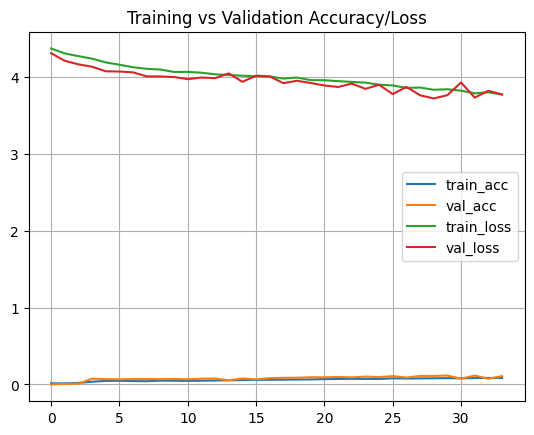

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.grid()
plt.title("Training vs Validation Accuracy/Loss")
plt.show()

Found 81093 files belonging to 76 classes.
Using 64875 files for training.
Found 81093 files belonging to 76 classes.
Using 16218 files for validation.
Detected 76 classes from folders
Epoch 1/50
2028/2028 ━━━━━━━━━━━━━━━━━━━━ 72s 28ms/step - accuracy: 0.0060 - loss: 4.2938 - val_accuracy: 7.3992e-04 - val_loss: 4.2651
Epoch 2/50
2028/2028 ━━━━━━━━━━━━━━━━━━━━ 45s 21ms/step - accuracy: 0.0097 - loss: 4.2913 - val_accuracy: 0.0137 - val_loss: 4.2448
Epoch 3/50
2028/2028 ━━━━━━━━━━━━━━━━━━━━ 45s 21ms/step - accuracy: 0.0171 - loss: 4.0744 - val_accuracy: 0.0134 - val_loss: 4.1751
Epoch 4/50
2028/2028 ━━━━━━━━━━━━━━━━━━━━ 44s 21ms/step - accuracy: 0.0304 - loss: 4.0795 - val_accuracy: 0.0442 - val_loss: 4.1011
Epoch 5/50
2028/2028 ━━━━━━━━━━━━━━━━━━━━ 44s 21ms/step - accuracy: 0.0522 - loss: 4.0014 - val_accuracy: 0.0662 - val_loss: 4.0831
Epoch 6/50
2028/2028 ━━━━━━━━━━━━━━━━━━━━ 44s 21ms/step - accuracy: 0.0623 - loss: 4.1014 - val_accuracy: 0.0359 - val_loss: 4.0407
Epoch 7/50
2028/202

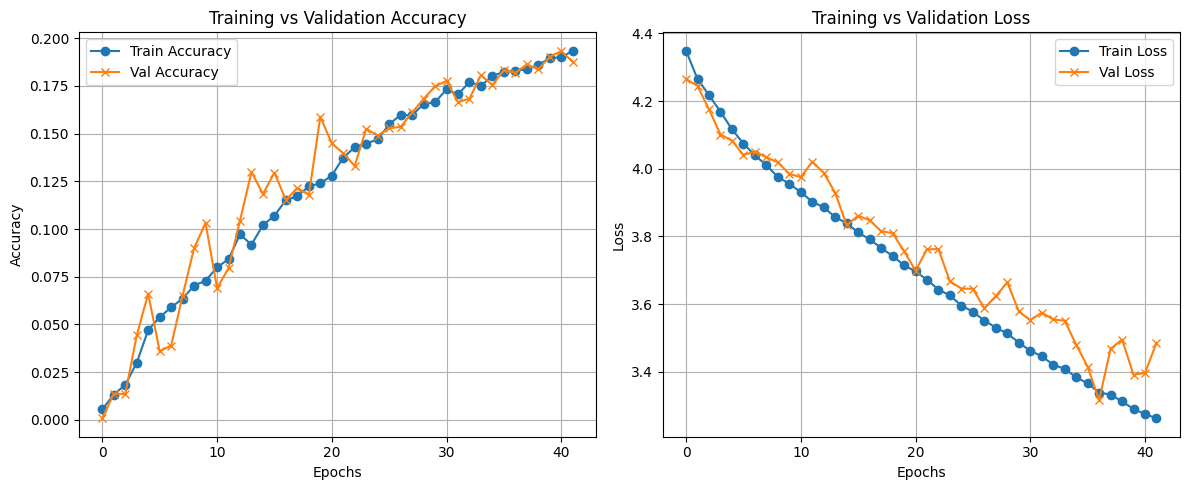

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# === 1. Parameters ===
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
DATASET_DIR = "/content/kaggle_dataset_cw_enriched_v3/processed_crops"

# === 2. Load Raw Datasets ===
train_ds_raw = tf.keras.utils.image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int'
)
val_ds_raw = tf.keras.utils.image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int'
)

# === 3. Class Info ===
class_names = train_ds_raw.class_names
num_classes = len(class_names)
print(f"Detected {num_classes} classes from folders")

# === 4. Normalize ===
def normalize(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_ds = train_ds_raw.map(normalize).shuffle(512).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds_raw.map(normalize).prefetch(tf.data.AUTOTUNE)

# === 5. Compute Class Weights ===
y_train = np.array([y.numpy() for _, y in train_ds_raw.unbatch()])
true_classes = np.unique(y_train)

weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=true_classes,
    y=y_train
)
class_weights = dict(zip(true_classes, weights))


# === 6. Build Model ===
base_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=IMG_SIZE + (3,)
)
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# === 7. Callbacks ===
callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ModelCheckpoint("best_model.keras", monitor="val_loss", save_best_only=True)
]

# === 8. Train ===
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    class_weight=class_weights,
    callbacks=callbacks
)

# === 9. Plot Accuracy and Loss ===
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='x')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.grid(True)
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='x')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
